In [74]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# DATA PREPARATION

In [75]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised=True, shuffle_files = True, split=['train'])

In [76]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(106, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [77]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

    return train_dataset, val_dataset, test_dataset

In [78]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [79]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# DATA VISUALIZATION

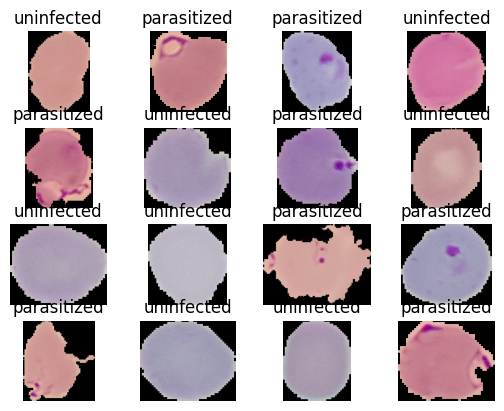

In [80]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [81]:
dataset_info.features['label'].int2str(1)

'uninfected'

In [82]:
dataset_info.features['label'].int2str(0)

'parasitized'

# DATA PREPROCESSING

In [83]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [84]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
train_dataset 

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [85]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [86]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [87]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [89]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# MODELING

In [90]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation = "relu"),
    BatchNormalization(),
    
    Dense(10, activation = "relu"),
    BatchNormalization(),
    
    Dense(1, activation = "sigmoid"),
])
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

# TRAINING

In [91]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [92]:
lenet_model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = 'accuracy'
)

In [93]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset,  epochs = 20, verbose = 1)

Epoch 1/20
689/689 [==============================] - 321s 463ms/step - loss: 0.5093 - accuracy: 0.7463 - val_loss: 0.9502 - val_accuracy: 0.6995
Epoch 2/20
689/689 [==============================] - 322s 467ms/step - loss: 0.2611 - accuracy: 0.9023 - val_loss: 0.6628 - val_accuracy: 0.8396
Epoch 3/20
689/689 [==============================] - 319s 463ms/step - loss: 0.2057 - accuracy: 0.9287 - val_loss: 0.1877 - val_accuracy: 0.9383
Epoch 4/20
689/689 [==============================] - 327s 474ms/step - loss: 0.1885 - accuracy: 0.9359 - val_loss: 0.2315 - val_accuracy: 0.9238
Epoch 5/20
689/689 [==============================] - 325s 471ms/step - loss: 0.1641 - accuracy: 0.9449 - val_loss: 0.2020 - val_accuracy: 0.9412
Epoch 6/20
689/689 [==============================] - 319s 463ms/step - loss: 0.1699 - accuracy: 0.9415 - val_loss: 0.3186 - val_accuracy: 0.9136
Epoch 7/20
689/689 [==============================] - 318s 461ms/step - loss: 0.1624 - accuracy: 0.9458 - val_loss: 0.1681 -

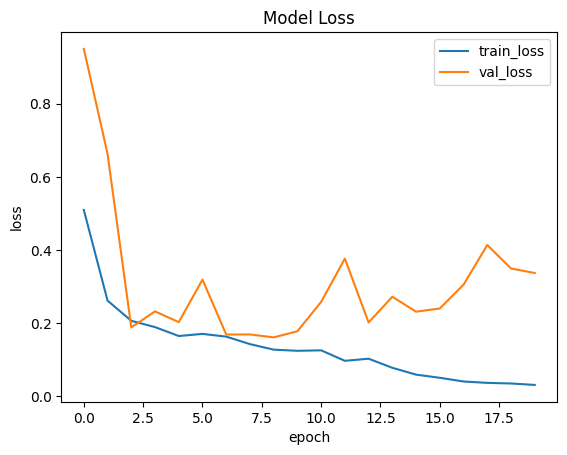

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

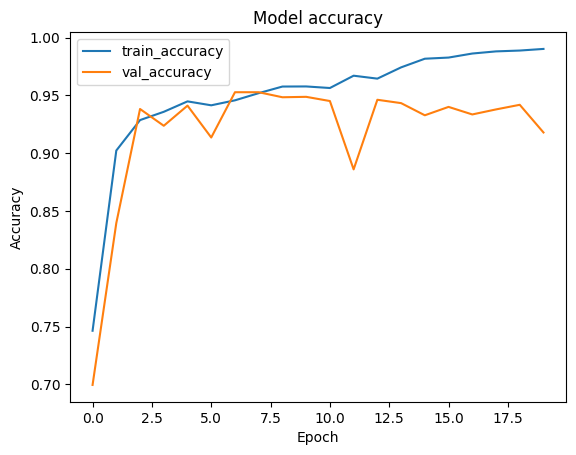

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [98]:
test_dataset = test_dataset.batch(1)

In [99]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 28s 9ms/step - loss: 0.3023 - accuracy: 0.9224


[0.302287220954895, 0.9223793745040894]

In [123]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 3s 3s/step


'Uninfected'

In [124]:
def parasite_or_not (x):
    if(x<0.5):
        return str('P')
    else:
        return str('U')

1/1 [==============================] - 0s 30ms/step


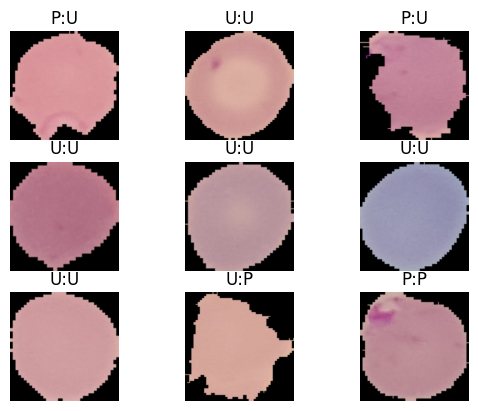

In [130]:
for i, (image, label) in enumerate(test_dataset.take(9)):

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])  # Assuming image is a 3D array representing an image.
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
    plt.axis('off')